<a href="https://colab.research.google.com/github/vgorbikov/optimization_mthds/blob/main/lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Вариант 8




## Задание

**А**. Методом перебора найти точку минимума $(x_1^*, x_2^*)$ функции $f(x_1, x_2)$ на множестве $[x_1', x_1''] \times [x_2', x_2'']$ с точностью $\epsilon$ и минимальное значение $f_*$:
$$f(x_1, x_2) = (x_2 - x_1^2)^2 + (1 - x_1^2)$$
$$[x_1', x_1''] \times [x_2', x_2'']= [-1, 2] \times [-3, 3]$$
$$\epsilon = 0.01$$

**Б**: Методом Ньютона найти точку минимума $(x_1^*, x_2^*)$ той же функции $f(x_1, x_2)$ на множестве $[x_1', x_1''] \times [x_2', x_2'']$ с точностью $\epsilon$ и минимальное значение $f_*$, начальную точку определить самостоятельно, сравнить время поиска точки минимума двумя предложенными алгоритмами.


## Подготовка

In [27]:
from typing import Callable, Tuple
import time

from numpy import ndarray
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd.functional import hessian



# исследуемая функция
target_f = lambda x1, x2: (x2-x1**2)**2 + (1-x1**2)
target_grad = lambda x1, x2: [4*(x2-x1**2)*x1 - 2*x1, 2*(x2-x1**2)]
bounds = ((-1, 2), (-3, 3))
eps = 0.01

#более простая функция для проверки
parab = lambda x1, x2: (x1 - 1.3)**2 + (x2 + 4.76)**2
para_grad = lambda x1, x2: [2*(x1-1.3), 2*(x2+4.76)]

In [ ]:
def timer():
  pass

In [131]:
def show_area_3d(func: Callable[[float], float], bounds_x1: Tuple[float], bounds_x2: Tuple[float],):
  step_size = min(bounds_x1[1]-bounds_x1[0], bounds_x2[1]-bounds_x2[0])/100

  points = np.array([
      [(bounds_x1[0]+i1*step_size, bounds_x2[0]+i2*step_size) for i1 in range(round((bounds_x1[1]-bounds_x1[0])/step_size))]
      for i2 in range(round((bounds_x2[1]-bounds_x2[0])/step_size))])
  values = np.array([[func(*point) for point in row] for row in points])

  fig = plt.figure(figsize=(8, 8))
  ax_3d = fig.add_subplot(projection='3d')

  ax_3d.set_xlabel('x1')
  ax_3d.set_ylabel('x2')

  x1grid, x2grid = np.meshgrid([p[0] for p in points[0]], [p[0][1] for p in points])

  ax_3d.plot_wireframe(x1grid, x2grid, values, color='grey')
  fig.show()

  return ax_3d, fig

График параболической функции


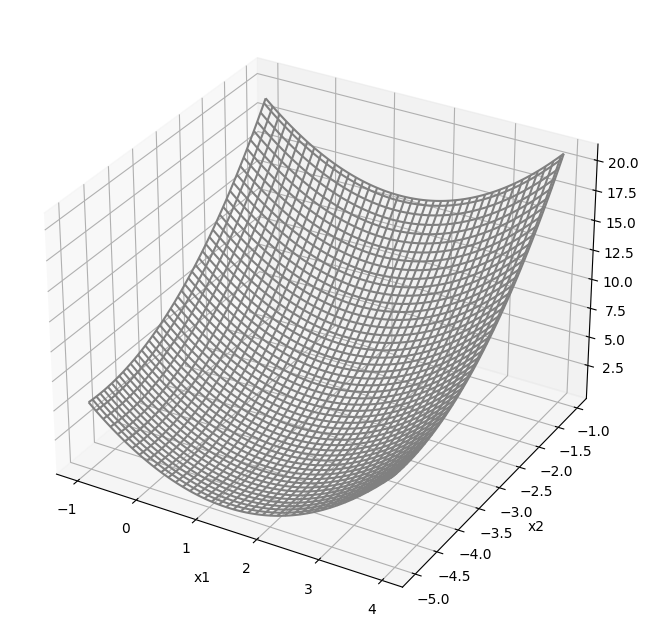

In [132]:
show_area_3d(parab, (-1, 4), (-5, -1))
print("График параболической функции")

График исследуемой функции


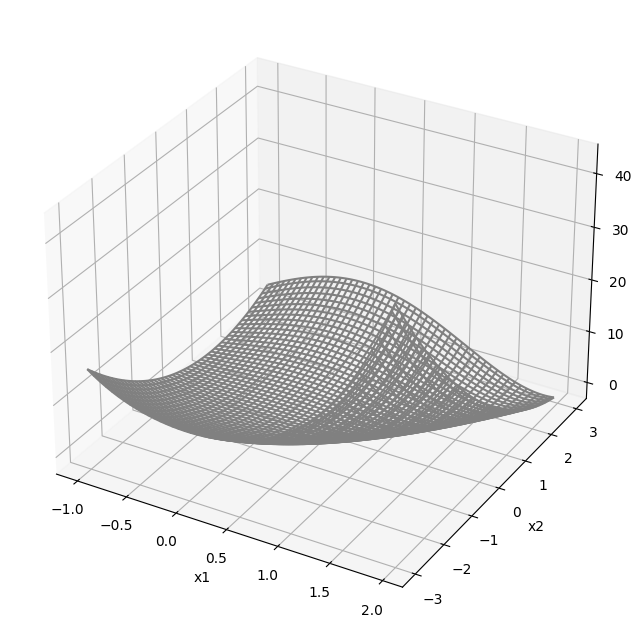

In [133]:
show_area_3d(target_f, bounds[0], bounds[1])
print("График исследуемой функции")

## Решение


### Пункт **А**:

In [106]:
def bruteforce_mthd(f: Callable[[float], float], bounds_x1: Tuple[float], bounds_x2: Tuple[float], accuracy: float, imshow: bool = 'False'):
  step_size = np.sqrt(accuracy**2/2)*0.95
  points = np.array([
      [(bounds_x1[0]+i1*step_size, bounds_x2[0]+i2*step_size) for i1 in range(round((bounds_x1[1]-bounds_x1[0])/step_size))]
      for i2 in range(round((bounds_x2[1]-bounds_x2[0])/step_size))])
  values = np.array([[f(*point) for point in row] for row in points])

  min_index = np.argmin(values)
  min_point = points[min_index//points.shape[1]][min_index%points.shape[1]]
  min_f = values.flatten()[min_index]

  return min_point, min_f

Точка минимума: (x1*, x2*) = (1.2973899320750926, -4.7581694808342005) 
Значение минимума: f* = 1.0163254988989165e-05


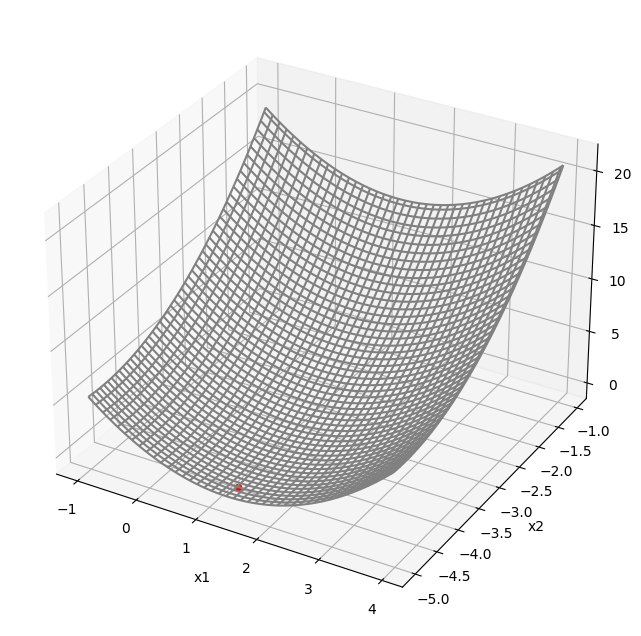

In [135]:
#параболическая функция
answer = bruteforce_mthd(parab, (-1, 4), (-5, -1), 0.01, True)
print(f'Точка минимума: (x1*, x2*) = ({answer[0][0]}, {answer[0][1]}) \nЗначение минимума: f* = {answer[1]}')

ax_p, fig_p = show_area_3d(parab, (-1, 4), (-5, -1))
ax_p.scatter(*answer[0], answer[1], color='red')
fig_p.show()

Точка минимума: (x1*, x2*) = (1.86837865788323, 2.992022863774803) 
Значение минимума: f* = -2.2420214617896463


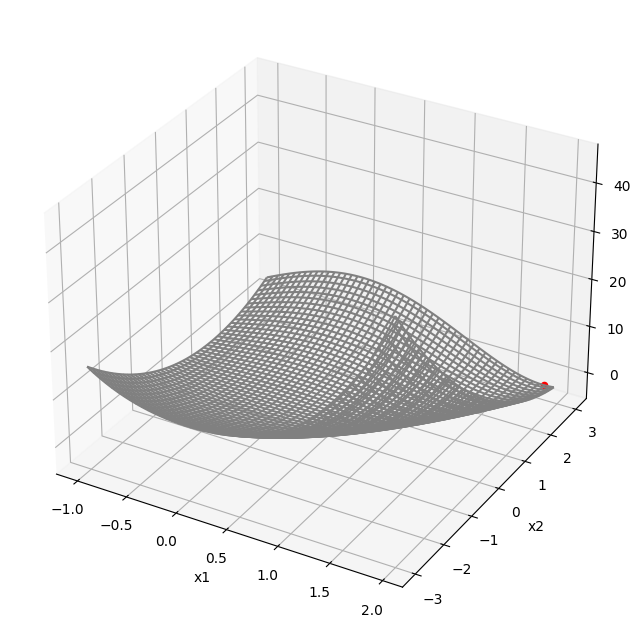

In [137]:
#заданная функция
answer = bruteforce_mthd(target_f, bounds[0], bounds[1], eps, True)
print(f'Точка минимума: (x1*, x2*) = ({answer[0][0]}, {answer[0][1]}) \nЗначение минимума: f* = {answer[1]}')

ax_t, fig_t = show_area_3d(target_f, bounds[0], bounds[1])
ax_t.scatter(*answer[0], answer[1], color='red')
fig_t.show()

### Пункт **B**:

In [175]:
def newtone_mthd(f, grad_f, bounds_x1: Tuple[float], bounds_x2: Tuple[float], start_point: Tuple[float], accuracy: float):
  print(f'Начальное приближение: {start_point}')

  x0 = torch.tensor(start_point, dtype=float)

  hess = torch.tensor(hessian(f, (x0[0], x0[1])))
  inv_hess = torch.linalg.inv(hess)
  grad = torch.tensor(grad_f(*x0), dtype=float)

  old_x = torch.tensor([bounds_x1[0], bounds_x2[1]])

  while np.sqrt((old_x[0]-x0[0])**2 + (old_x[1]-x0[1])**2) >= accuracy:
    old_x = np.copy(x0)
    step = torch.matmul(inv_hess, grad)

    # # ограничиваем оптимизацию в заданной области
    # if x0[0] - step[0] < bounds_x1[0]:
    #   step[0] = x0[0] - bounds_x1[0]
    # if x0[0] - step[0] > bounds_x1[1]:
    #   step[0] = x0[0] - bounds_x1[1]
    # if x0[1] - step[1] < bounds_x2[0]:
    #   step[1] = x0[1] - bounds_x2[0]
    # if x0[1] - step[1] > bounds_x2[1]:
    #   step[1] = x0[1] - bounds_x2[1]

    # ограничиваем оптимизацию в заданной области
    if x0[0] - step[0] < bounds_x1[0]:
      print("<!>Расхождение<!>: Выход за заданную область")
      break
    if x0[0] - step[0] > bounds_x1[1]:
      print("<!>Расхождение<!>: Выход за заданную область")
      break
    if x0[1] - step[1] < bounds_x2[0]:
      print("<!>Расхождение<!>: Выход за заданную область")
      break
    if x0[1] - step[1] > bounds_x2[1]:
      print("<!>Расхождение<!>: Выход за заданную область")
      break

    x0 -= step

    print(f'\t-Приближение: (x1*, x2*) = ({x0[0]}, {x0[1]}); Значение: f* = {f(*x0)}')

    hess = torch.tensor(hessian(f, (x0[0], x0[1])))
    inv_hess = torch.linalg.inv(hess)
    grad = torch.tensor(grad_f(*x0), dtype=float)

  return x0, f(*x0)

Начальное приближение: (1.5, 1)
	-Приближение: (x1*, x2*) = (1.3, -4.76); Значение: f* = 0.0
	-Приближение: (x1*, x2*) = (1.3, -4.76); Значение: f* = 0.0
Точка минимума: (x1*, x2*) = (1.3, -4.76) 
Значение минимума: f* = 0.0


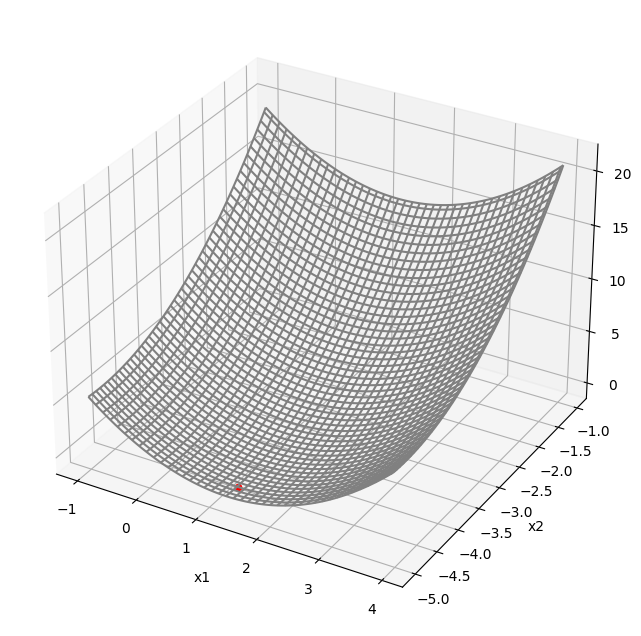

In [176]:
#параболическая функция
start_point_parab = (1.5, 1)
answer = newtone_mthd(parab, para_grad, (-1, 4), (-5, -1), start_point_parab, eps)
print(f'Точка минимума: (x1*, x2*) = ({answer[0][0]}, {answer[0][1]}) \nЗначение минимума: f* = {answer[1]}')

ax_p, fig_p = show_area_3d(parab, (-1, 4), (-5, -1))
ax_p.scatter(*answer[0], answer[1], color='red')
fig_p.show()

Начальное приближение: (0, 3)
	-Приближение: (x1*, x2*) = (0.0, 0.0); Значение: f* = 1.0
	-Приближение: (x1*, x2*) = (0.0, 0.0); Значение: f* = 1.0
Точка минимума: (x1*, x2*) = (0.0, 0.0) 
Значение минимума: f* = 1.0


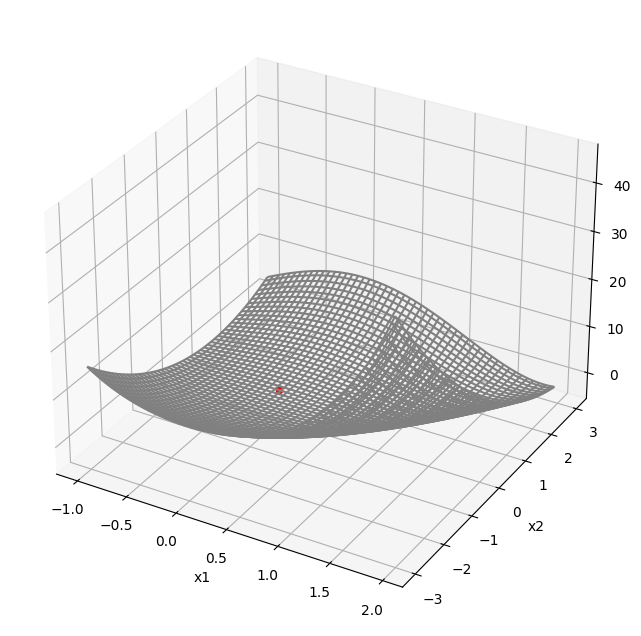

In [178]:
#заданная функция -  вариант с начальным приближением (0, 3)
start_point_targetf = (0, 3)
answer = newtone_mthd(target_f, target_grad, bounds[0], bounds[1], start_point_targetf, eps)
print(f'Точка минимума: (x1*, x2*) = ({answer[0][0]}, {answer[0][1]}) \nЗначение минимума: f* = {answer[1]}')

ax_t, fig_t = show_area_3d(target_f, bounds[0], bounds[1])
ax_t.scatter(*answer[0], answer[1], color='red')
fig_t.show()

Начальное приближение: (1.87, 2.99)
<!>Расхождение<!>: Выход за заданную область
Точка минимума: (x1*, x2*) = (1.87, 2.99) 
Значение минимума: f* = -2.23995239


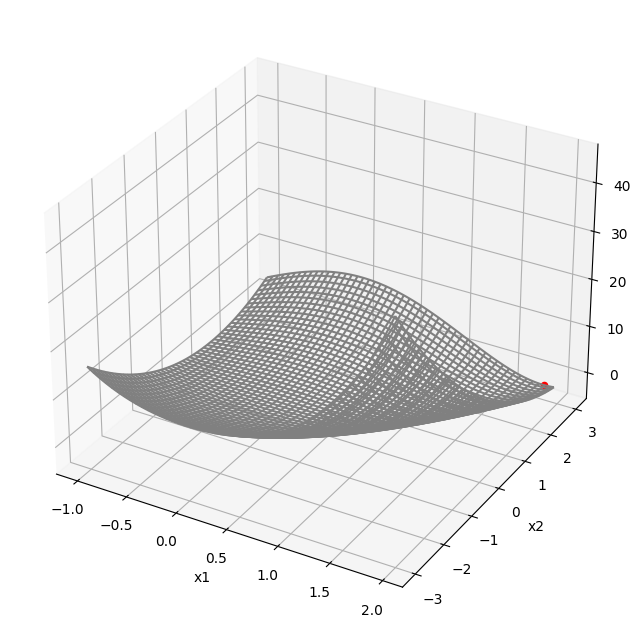

In [197]:
#заданная функция -  вариант с начальным приближением (..., ...)
start_point_targetf = (1.87, 2.99)
answer = newtone_mthd(target_f, target_grad, bounds[0], bounds[1], start_point_targetf, eps)
print(f'Точка минимума: (x1*, x2*) = ({answer[0][0]}, {answer[0][1]}) \nЗначение минимума: f* = {answer[1]}')

ax_t, fig_t = show_area_3d(target_f, bounds[0], bounds[1])
ax_t.scatter(*answer[0], answer[1], color='red')
fig_t.show()

<ipython-input-198-72a83c153212>:1: RuntimeWarning: invalid value encountered in log
  show_area_3d(lambda x1, x2: np.log(target_f(x1, x2)), bounds[0], bounds[1])


График логарифма исследуемой функции


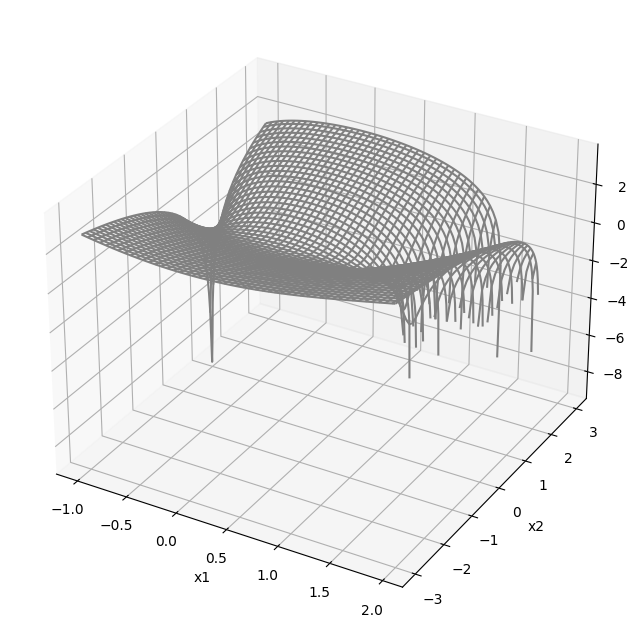

In [198]:
show_area_3d(lambda x1, x2: np.log(target_f(x1, x2)), bounds[0], bounds[1])
print("График логарифма исследуемой функции")